In [1]:
%load_ext autoreload
%autoreload 2

# Fixing issues with grid-based posterior sampling using slice sampling

Two types of issues arise when using grid approximations for posterior inference:

1. Grid too short: the posterior concentrates at a value outside the boundaries of the data-adaptive CGPM grid
    1. a. special case: posterior not well behaved: the posterior explodes near zero (e.g. alpha for a CRP with a single cluster) or towards infinity (e.g. all normalgamma clusters have exactly the same mean)

2. Grid too coarse: the posterior concentrates on a single value in the CGPM grid

Moreover, we'll show that even for an optimal handcoded grid, gibbs sampling introduces local minima that can keep us from drawing representative posterior samples. We'll show how to fix both of these problems using an implementation of slice sampling with clever initialization.

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

# Generating synthetic data

We'll begin by generating a dataset with a bernoulli and a categorical variable which stand in a deterministic relationship to one another

In [3]:
bernoulli = np.repeat([0, 1], 100)
categorical = np.repeat([0, 1], 100)

In [4]:
df = pd.DataFrame({"bernoulli": bernoulli, "categorical": categorical})

We'll then assume we're in the process of learning a crosscat model from these data, and that our current structure hypothesis posits a DPMM with clusters: one containing the first half and the other the second half of the data.

In [5]:
from inferenceql_auto_modeling.cgpm import CGPMModel

In [6]:
schema = {"bernoulli": "bernoulli", "categorical": "categorical", }

In [7]:
mapping_table = {"categorical": {"false": 0, "true": 1}}

In [8]:
additional_metadata = {
    "Zrv": {0: np.repeat([0, 1], 100)},
}

In [9]:
wrapper = CGPMModel.from_data(
    df, schema, mapping_table, model="DPMM", additional_metadata=additional_metadata
)

# Analyzing the grid posterior

Now, we'll look at what the column hyperparameters posterior looks like over the default CGPM grid:

In [10]:
bernoulli_dim = wrapper.cgpm.dim_for(0)
categorical_dim = wrapper.cgpm.dim_for(1)

grid = bernoulli_dim.hyper_grids

In [11]:
from inferenceql_auto_modeling.slice_sampling import get_set_logp, set_hyper, slice_sampling

In [12]:
def get_posterior(dim, hyper, grid):
    posterior = np.array([get_set_logp(bernoulli_dim, hyper, val) for val in grid])

    return posterior

In [13]:
def reset_hypers(bernoulli_dim, categorical_dim):
    set_hyper(bernoulli_dim, "alpha", 1)
    set_hyper(bernoulli_dim, "beta", 1)
    set_hyper(categorical_dim, "alpha", 1)

In [14]:
def get_beta_posterior(bernoulli_dim, alpha_grid, beta_grid):
    n_grid = len(alpha_grid)
    alphas, betas, posterior = np.zeros((3, n_grid * n_grid))
    for i, beta_val in tqdm(enumerate(beta_grid)):
        set_hyper(bernoulli_dim, "beta", beta_val)
        posterior[i*n_grid: (i+1) * n_grid] = get_posterior(bernoulli_dim, "alpha", alpha_grid)
        alphas[i*n_grid: (i+1) * n_grid] = alpha_grid
        betas[i*n_grid: (i+1) * n_grid] = beta_val
    
    return pd.DataFrame({
        "log_alpha": np.log(alphas),
        "log_beta": np.log(betas),
        "posterior": posterior
    })

look, the posterior concentrates at the boundaries

In [15]:
df = get_beta_posterior(bernoulli_dim, grid["alpha"], grid["beta"])

30it [00:00, 4699.85it/s]


Text(0.5, 0.92, 'Log likelihood of a bernoulli dimension\nas a function of hyperparameters (data-driven CGPM grid)')

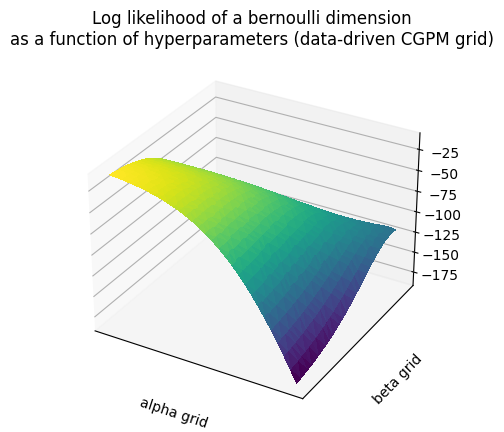

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_trisurf(df['log_alpha'], df['log_beta'], df['posterior'], cmap=cm.viridis,
                       linewidth=0, antialiased=False)
plt.xticks([])
plt.yticks([])
plt.xlabel("alpha grid")
plt.ylabel("beta grid")
plt.title("Log likelihood of a bernoulli dimension\nas a function of hyperparameters (data-driven CGPM grid)")

This plot illustrates two types of issues that can arise in CGPM's column hyperparameter sweeps:

A. Inadequate grid: the posterior is concentrated near the boundary of the grid, so that we have no hope of drawing representative samples
B. 

# Grid posterior yields nonrepresentative samples

this presents an issue if we use CGPM's column hyperparameter transition kernel:

In [17]:
reset_hypers(bernoulli_dim, categorical_dim)

In [18]:
wrapper.cgpm.transition_dim_hypers()

In [19]:
bernoulli_dim.hyper_grids

{'alpha': array([  1.        ,   1.20045494,   1.44109205,   1.72996607,
          2.07674631,   2.49304036,   2.99278261,   3.59270066,
          4.31287524,   5.17741237,   6.21525024,   7.46112784,
          8.95674774,  10.75217205,  12.90749801,  15.49486971,
         18.60089284,  22.32953363,  26.80559888,  32.17891351,
         38.62933558,  46.3727766 ,  55.66842859,  66.82743992,
         80.22333016,  96.30449273, 115.60920372, 138.78363933,
        166.60350496, 200.        ]),
 'beta': array([  1.        ,   1.20045494,   1.44109205,   1.72996607,
          2.07674631,   2.49304036,   2.99278261,   3.59270066,
          4.31287524,   5.17741237,   6.21525024,   7.46112784,
          8.95674774,  10.75217205,  12.90749801,  15.49486971,
         18.60089284,  22.32953363,  26.80559888,  32.17891351,
         38.62933558,  46.3727766 ,  55.66842859,  66.82743992,
         80.22333016,  96.30449273, 115.60920372, 138.78363933,
        166.60350496, 200.        ])}

In [20]:
bernoulli_dim.hypers

{'alpha': 1.2004549366776545, 'beta': 1.0}

As we can see, sampling from the grid posterior gets us stuck near the boundary of the grid

# Refinining the grid is not enough: failures of gibbs sampling 

In [21]:
bernoulli_dim.hyper_grids = {
    "alpha": np.geomspace(1e-10, 10, 30),
    "beta": np.geomspace(1e-10, 10, 30)
}
grid = bernoulli_dim.hyper_grids

In [22]:
df = get_beta_posterior(bernoulli_dim, grid["alpha"], grid["beta"])

30it [00:00, 5167.94it/s]


Text(0.5, 0.92, 'Log likelihood of a bernoulli dimension\nas a function of hyperparameters (handcoded grid)')

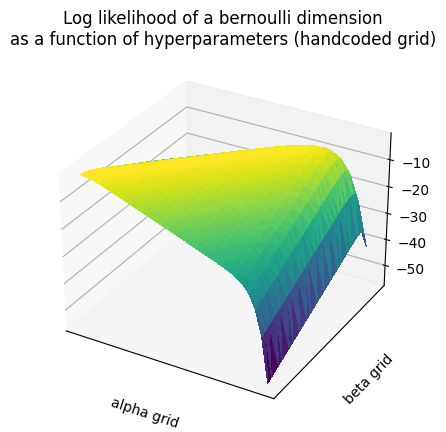

In [23]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_trisurf(df['log_alpha'], df['log_beta'], df['posterior'], cmap=cm.viridis,
                       linewidth=0, antialiased=False)
plt.xticks([])
plt.yticks([])
plt.xlabel("alpha grid")
plt.ylabel("beta grid")
plt.title("Log likelihood of a bernoulli dimension\nas a function of hyperparameters (handcoded grid)")

The grid seems to capture probability mass in a much more homogenous way now that we've introduced alpha and beta values much closer to 0. How to column hyper transitions behave with this new grid?

In [24]:
wrapper.cgpm.transition_dim_hypers()

In [25]:
bernoulli_dim.hypers

{'alpha': 0.009236708571873845, 'beta': 0.7278953843983131}

Surprisingly, we're still very far from the very small high probability values (around 1e-10). Why is that? Remember that the 2-dimensional distribution over alpha and beta is one dimension at a time, through gibbs sampling. Let's slice the above graph at the current beta value to look at what the one dimensional posterior looks like for alpha:

In [26]:
beta = bernoulli_dim.hypers["beta"]
alpha_df = df[df["log_beta"] == np.log(beta)]

Text(0, 0.5, 'log likelihood')

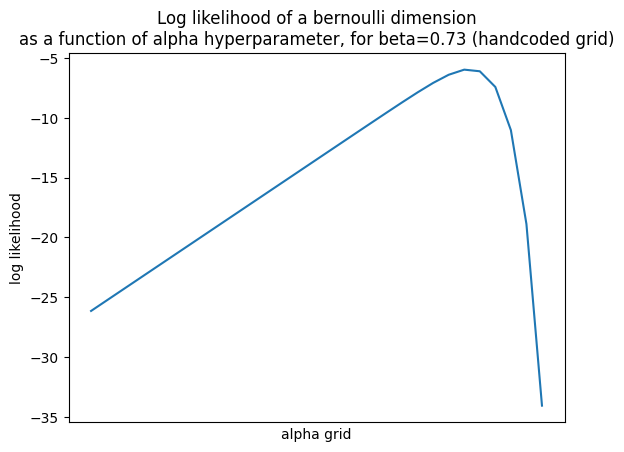

In [27]:
plt.title(f"Log likelihood of a bernoulli dimension\nas a function of alpha hyperparameter, for beta={beta:.2f} (handcoded grid)")
plt.plot(alpha_df["log_alpha"], alpha_df["posterior"])
plt.xticks([])
plt.xlabel("alpha grid")
plt.ylabel("log likelihood")

As we can see, even though the two-dimensional posterior is concentrated around (0, 0), when doing one dimensional updates we get stuck in local minima: changing the value of alpha too much with a fixed value of beta would result in a class imbalance between positive and negative bernoulli trials, leading to a low likelihood.

# Slice sampling (with careful initialization) yields representative samples

Our proposed solution for the two above problems is the following:

- Solve issues with the grid being too short or too coarse by doing away with the grid entirely, and using slice sampling slice sampling (Neal 2003).
- Solve issues with local minima in gibbs sampling by initializing from the n-dimensional MAP.

In [28]:
reset_hypers(bernoulli_dim, categorical_dim)

In [29]:
wrapper.inference(N=1, kernels=["column_hypers"])

Completed: 1 iterations in 0.000285 minutes.


In [30]:
bernoulli_dim.hypers

{'alpha': 4.4811939898179905e-10, 'beta': 3.21139805399291e-09}